In [1]:
import numpy as np, pandas as pd
import torch, copy
from torch import nn
import os, sys
from pathlib import Path
import importlib.util
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import tensorflow as tf

data_dir = 'C:\\Users\\main\\Proton Drive\\laurin.koller\\My files\\ML\\kaggle\\Higgs-Data'

spec = importlib.util.spec_from_file_location("utils", data_dir + '\\utils.py')
u = importlib.util.module_from_spec(spec)
spec.loader.exec_module(u)

AUTO = tf.data.experimental.AUTOTUNE

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def accuracy(corr, pred):
    return 1 - np.sum(np.abs(corr - pred))/len(corr)

In [3]:
feature_description = {
    'features': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.float32),
}
decoder = u.make_decoder(feature_description)

train_files = tf.io.gfile.glob(data_dir + '\\training' + '\\*.tfrecord')#[:1]
valid_files = tf.io.gfile.glob(data_dir + '\\validation' + '\\*.tfrecord')#[:1]

# Count the number of samples in the train and validation datasets
# This takes a long time, so this was run once and it is not manually defined below
#training_size = u.count_samples(train_files)
#validation_size = u.count_samples(valid_files)

training_size = int(1.05e7/24)
validation_size = int(5e5/8)
training_size = int(1.05e7)
validation_size = int(5e5)
BATCH_SIZE_PER_REPLICA = 2 ** 11
batch_size = BATCH_SIZE_PER_REPLICA
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

print(f"steps_per_epoch: {steps_per_epoch}, validation_steps: {validation_steps}")

steps_per_epoch: 5126, validation_steps: 244


In [4]:
ds_valid = u.load_dataset(valid_files, decoder, ordered=True)
ds_valid = (
    ds_valid
    .cache()
    .repeat()
    .batch(validation_size)
    .prefetch(AUTO)
)
ds_valid_np = ds_valid.as_numpy_iterator()
valid_arr = next(iter(ds_valid_np))

In [22]:
train_info = pd.read_csv(data_dir + '\\DL info\\best_train_info.csv')
train_loss = train_info.loss_history.to_numpy()
train_auc = train_info.auc_history.to_numpy()

valid_info = pd.read_csv(data_dir + '\\DL info\\best_valid_info.csv')
valid_loss = valid_info.loss_history.to_numpy()
valid_auc = valid_info.auc_history.to_numpy()

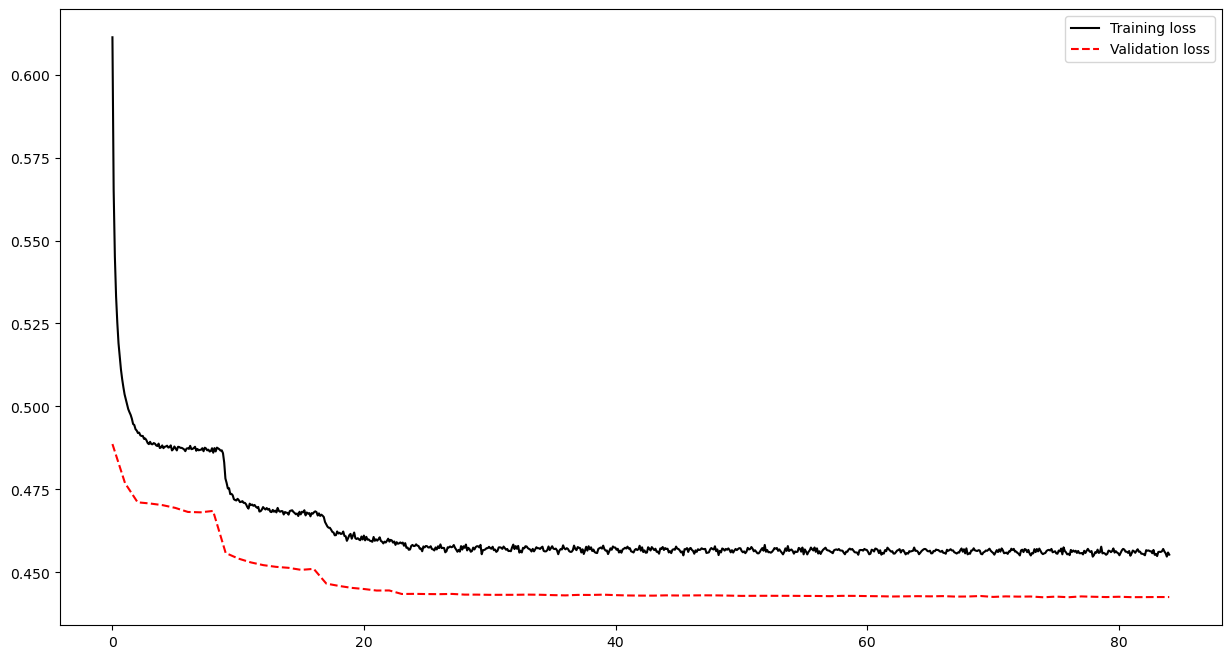

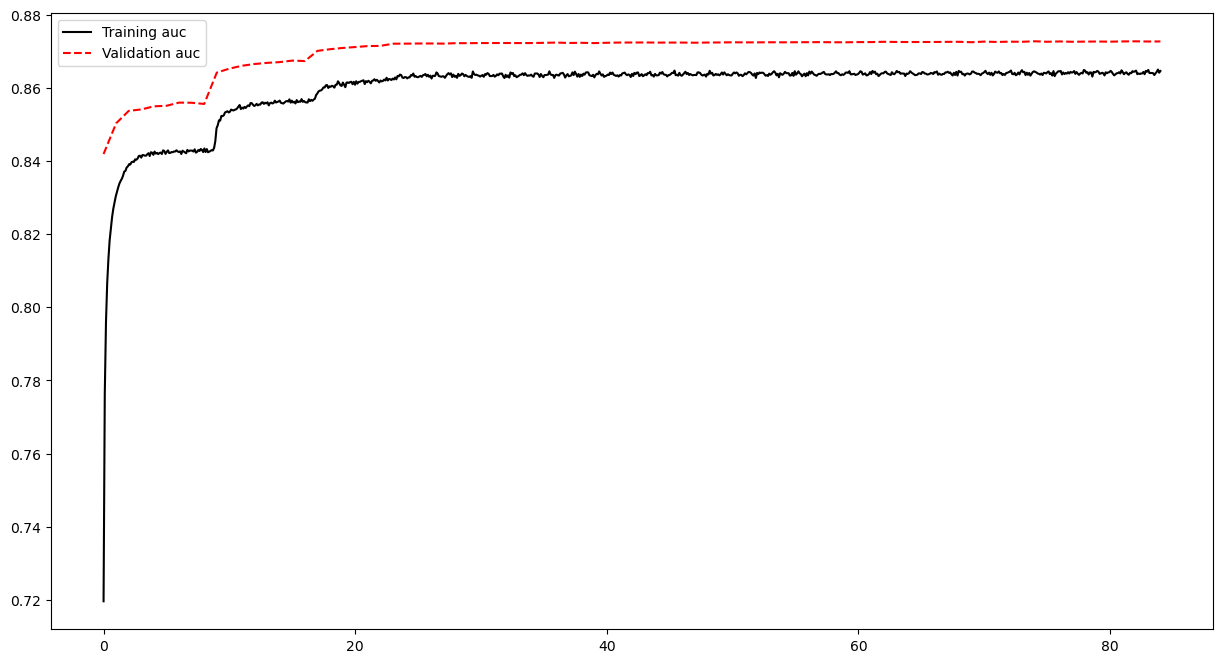

In [23]:
u.plot_training_info(train_loss, valid_loss, train_auc, valid_auc, n=500)

In [27]:
labels = valid_arr[1]

dl_data = pd.read_csv(data_dir + '\\predictions\\DL_prediction.csv')
dl_tensor = torch.tensor(np.array(dl_data).reshape(-1,))
dl_sig = nn.Sigmoid()(dl_tensor)
dl_arr = dl_sig.detach().cpu().numpy().reshape(-1,)
dl_class = np.random.default_rng(seed=42).binomial(n=1, p=dl_arr_proba)

rfc_data = pd.read_csv(data_dir + '\\predictions\\RFC_prediction.csv')
rfc_arr = np.array(rfc_data).reshape(-1,)

xgb_data = pd.read_csv(data_dir + '\\predictions\\XGB_prediction.csv')
xgb_arr = np.array(xgb_data).reshape(-1,)

In [28]:
labels.shape, dl_arr.shape, rfc_arr.shape, xgb_arr.shape

((500000,), (500000,), (500000,), (500000,))

In [70]:
t = (dl_arr_proba >= 0.5).astype(float)
roc_auc_score(labels, t)

np.float64(0.7959355565673046)

In [65]:
import random
tt = [1 if random.random() < q else 0 for q in dl_arr_proba]
roc_auc_score(labels, tt)

np.float64(0.7291774159487313)

In [69]:
roc_auc_score(labels, dl_tensor.detach().cpu().numpy().reshape(-1,))

np.float64(0.8823873740075657)

In [59]:
np.sum(np.abs(rfc_arr - xgb_arr)) / len(labels)

np.float64(0.113018)

In [29]:
roc_auc_score(labels, dl_arr), roc_auc_score(labels, rfc_arr), roc_auc_score(labels, xgb_arr)

(np.float64(0.8823873740075657),
 np.float64(0.8115280952431286),
 np.float64(0.8318195152407002))

In [76]:
accuracy(labels, dl_arr), accuracy(labels, rfc_arr), accuracy(labels, xgb_arr)

(np.float64(0.729884), np.float64(0.731482), np.float64(0.749708))